# Cat vs Dog

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview

SCORE(LogLoss): 0.03633 (TOP 1%)

In [1]:
import torch
from torch import nn, optim
import numpy as np
from sklearn.model_selection import train_test_split
from model import DogvsCatModel
import torch.utils.data as D
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt

cuda
accuracy:0.996


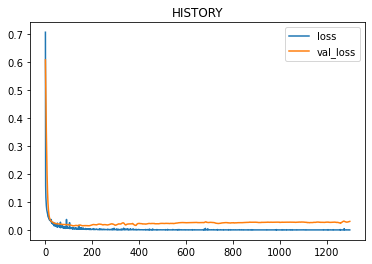

In [2]:
MINLOSS = np.inf
HISTORY = [[], []]
BATCHSIZE = 2048
EPOCHS = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

xTrain = np.load("x_train.npy")
yTrain = np.load("y_train.npy")

xTrain, xVal, yTrain, yVal = train_test_split(
    xTrain, yTrain, test_size=0.01, random_state=42
)

xTrain = torch.FloatTensor(xTrain)
xVal = torch.FloatTensor(xVal).to(DEVICE)
yTrain = torch.FloatTensor(yTrain)
yVal = torch.FloatTensor(yVal).unsqueeze(1).to(DEVICE)

TrainDataset = D.TensorDataset(xTrain, yTrain)
TrainLoader = D.DataLoader(dataset=TrainDataset, batch_size=BATCHSIZE, shuffle=True)

model = DogvsCatModel().to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    for xBatch, yBatch in TrainLoader:
        model.train()
        xBatch = xBatch.to(DEVICE)
        yBatch = yBatch.unsqueeze(1).to(DEVICE)
        res = model(xBatch)
        loss = criterion(res, yBatch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            res = model(xVal)
            val_loss = criterion(res, yVal)
        HISTORY[0].append(loss.item())
        HISTORY[1].append(val_loss.item())
        # print(f"loss: {loss.item()} val_loss: {val_loss.item()}")
        if val_loss.item() <= MINLOSS:
            MINLOSS = val_loss.item()
            torch.save(model, "checkpoint.pt")

model = torch.load("checkpoint.pt")
model.eval()
yVal = yVal.cpu().numpy()
with torch.no_grad():
    res = model(xVal, eval=True).cpu().numpy()
print(f"accuracy:{metrics.accuracy_score(res, yVal)}")
plt.plot(HISTORY[0], label="loss")
plt.plot(HISTORY[1], label="val_loss")
plt.legend()
plt.title("HISTORY")
plt.show()

In [3]:
xTest = np.load("x_test.npy")
yTest = np.load("y_test.npy")

xTest = torch.FloatTensor(xTest)
yTest = torch.FloatTensor(yTest)


TestDataset = D.TensorDataset(xTest, yTest)
TestLoader = D.DataLoader(dataset=TestDataset, batch_size=BATCHSIZE, shuffle=False)

submissions = []

for xBatch, _ in TestLoader:
    xBatch = xBatch.to(DEVICE)
    with torch.no_grad():
        res = model(xBatch, eval=False).cpu().numpy()
        submissions.append(res)
submissions = np.concatenate(submissions, axis=0)

In [4]:
submissions = pd.DataFrame({"label": submissions.reshape(-1)})
submissions.index += 1
submissions.to_csv("submissions.csv", index_label="id")